## ga_sim

This jn is intended to create simulations of dwarf galaxies and globular clusters using as field stars the catalog of DES. These simulations will be later copied to gawa jn, a pipeline to detect stellar systems with field's stars. In principle this pipeline read a table in data base with g and r magnitudes, subtract the extinction in each band, and randomize the positions in RA and DEC in order to avoid stellar systems in the FoV. The star clusters are inserted later, centered in each HP pixel with specific nside.

To complete all the steps you just have to run all the cells below in sequence.

Firstly, install the packages not available in the image via terminal. Restart the kernel and so you can run the cell bellow.

In [1]:
import numpy as np
from astropy.coordinates import SkyCoord
from astropy import units as u
import healpy as hp
import astropy.io.fits as fits
from astropy.table import Table
from astropy.io.fits import getdata
import sqlalchemy
import json
from pathlib import Path
import os
import sys
import parsl
from parsl.app.app import python_app, bash_app
from parsl.configs.local_threads import config
from time import sleep
from tqdm import tqdm
from ga_sim import (
    make_footprint,
    faker,
    join_cat,
    write_sim_clus_features,
    download_iso,
    read_cat,
    gen_clus_file,
    read_error,
    clus_file_results,
    join_cats_clean,
    split_files,
    clean_input_cat,
    clean_input_cat_dist
)

parsl.clear()
parsl.load(config)


Below are the items of the configuration for field stars and simulations. A small description follows as a comment.

In [2]:
# Main settings:
confg = "ga_sim.json"

# read config file
with open(confg) as fstream:
    param = json.load(fstream)

age_simulation = 1.2e10  # in years
Z_simulation = 0.001  # Assuming Z_sun = 0.0152

# Diretório para os resultados
os.system("mkdir -p " + param['results_path'])

# Reading reddening files
hdu_ngp = fits.open("sample_data/SFD_dust_4096_ngp.fits", memmap=True)
ngp = hdu_ngp[0].data

hdu_sgp = fits.open("sample_data/SFD_dust_4096_sgp.fits", memmap=True)
sgp = hdu_sgp[0].data


Downloading the isochrone table with the last improvements from Padova.
Printing age and metalicity of isochrone downloaded. Try one more time in case of problems. Sometimes there is a problem with the connection to Padova.

In [3]:
download_iso(param['padova_version_code'], param['survey'], Z_simulation,
             age_simulation, param['av_simulation'], param['file_iso'])


Checking age and metalicity of the isochrone:

In [4]:
# Reading [M/H], log_age, mini, g
iso_info = np.loadtxt(param['file_iso'], usecols=(1, 2, 3, 26), unpack=True)
FeH_iso = iso_info[0][0]
logAge_iso = iso_info[1][0]
m_ini_iso = iso_info[2]
g_iso = iso_info[3]

print('[Fe/H]={:.2f}, Age={:.2f} Gyr'.format(FeH_iso, 10**(logAge_iso-9)))

mM_mean = (param['mM_max'] + param['mM_min']) / 2.
print(np.max(m_ini_iso[g_iso + mM_mean < param['mmax']]))
mean_mass = (np.min(m_ini_iso[g_iso + mM_mean < param['mmax']]) +
             np.max(m_ini_iso[g_iso + mM_mean < param['mmax']])) / 2.

print('Mean mass (M_sun): {:.2f}'.format(mean_mass))


[Fe/H]=-1.19, Age=12.00 Gyr
0.8225140572
Mean mass (M_sun): 0.81


In [5]:
hpx_ftp = make_footprint(param['ra_min'], param['ra_max'], param['dec_min'], param['dec_max'],
                         param['nside_ftp'], output_path=param['results_path'])
print(len(hpx_ftp))


442147


Reading the catalog and writing as a fits file (to avoid read from the DB many times in the case the same catalog will be used multiple times).

In [6]:
RA, DEC, MAG_G, MAGERR_G, MAG_R, MAGERR_R = read_cat(
    param['vac_ga'], param['ra_min'], param['ra_max'], param['dec_min'], param['dec_max'],
    param['mmin'], param['mmax'], param['cmin'], param['cmax'],
    "DES_Y6_Gold_v1_derred.fits", 1.19863, 0.83734, ngp, sgp, param['results_path'])


The cells below reads the position, calculates the extinction using the previous function and <br>
correct the aparent magnitude (top of the Galaxy), filter the stars for magnitude and color ranges, <br> 
and writes a file with the original position of the stars and corrected magnitudes.

## Simulation of dwarf galaxies and globular clusters

In fact, the dwarf galaxies and globular clusters are very similar in terms of stellar populations. Dwarf galaxies
have a half-light radius larger than globular clusters (given the amount of dark matter) with the same absolute magnitude. The code below simulates stars using a Kroupa or Salpeter IMF, and an exponential radius for the 2D distribution of stars. 

Generating the properties of clusters based on properties stated above. Writting to file 'objects.dat'.

In [7]:
RA_pix, DEC_pix, r_exp, ell, pa, dist, mass, mM, hp_sample_un = gen_clus_file(
    param['ra_min'],
    param['ra_max'],
    param['dec_min'],
    param['dec_max'],
    param['nside_ini'],
    param['border_extract'],
    param['mM_min'],
    param['mM_max'],
    param['log10_rexp_min'],
    param['log10_rexp_max'],
    param['log10_mass_min'],
    param['log10_mass_max'],
    param['ell_min'],
    param['ell_max'],
    param['pa_min'],
    param['pa_max'],
    param['results_path']
)


## Dist stars
Reading data from magnitude and errors.



In [8]:
mag1_, err1_, err2_ = read_error(param['file_error'], 0.015, 0.015)


Now simulating the clusters using 'faker' function.

In [9]:
@python_app
def faker_app(N_stars_cmd, frac_bin, IMF_author, x0, y0, rexp, ell_, pa, dist, hpx, output_path):

    global param

    faker(
        N_stars_cmd,
        frac_bin,
        IMF_author,
        x0,
        y0,
        rexp,
        ell_,
        pa,
        dist,
        hpx,
        param['cmin'],
        param['cmax'],
        param['mmin'],
        param['mmax'],
        mag1_,
        err1_,
        err2_,
        param['file_iso'],
        output_path
    )


# Diretório dos arquivo _clus.dat gerados pela faker.
fake_clus_path = param['results_path'] + '/fake_clus'

futures = list()

# Cria uma Progressbar (Opcional)
with tqdm(total=len(hp_sample_un), file=sys.stdout) as pbar:
    pbar.set_description("Submit Parsls Tasks")

    # Submissão dos Jobs Parsl
    for i in range(len(hp_sample_un)):
        # Estimating the number of stars in cmd dividing mass by mean mass
        N_stars_cmd = int(mass[i] / mean_mass)
        # os.register_at_fork(after_in_child=lambda: _get_font.cache_clear())
        futures.append(
            faker_app(
                N_stars_cmd,
                param['frac_bin'],
                param['IMF_author'],
                RA_pix[i],
                DEC_pix[i],
                r_exp[i],
                ell[i],
                pa[i],
                dist[i],
                hp_sample_un[i],
                output_path=fake_clus_path
            )
        )

        pbar.update()

# Progressbar para acompanhar as parsl.tasks.
print("Tasks Done:")
with tqdm(total=len(futures), file=sys.stdout) as pbar2:
    # is_done é um array contendo True ou False para cada task
    # is_done.count(True) retorna a quantidade de tasks que já terminaram.
    is_done = list()
    done_count = 0
    while is_done.count(True) != len(futures):
        is_done = list()
        for f in futures:
            is_done.append(f.done())

        # Só atualiza a pbar se o valor for diferente.
        if is_done.count(True) != done_count:
            done_count = is_done.count(True)
            # Reset é necessário por que a quantidade de iterações
            # é maior que a quantidade de jobs.
            pbar2.reset(total=len(futures))
            # Atualiza a pbar
            pbar2.update(done_count)

        if done_count < len(futures):
            sleep(3)


Submit Parsls Tasks: 100%|██████████| 66/66 [00:00<00:00, 72.48it/s]
Tasks Done:
100%|██████████| 66/66 [00:00<00:00, 17459.73it/s]


Now functions to join catalogs of simulated clusters and field stars, and to estimate signal-to-noise ratio.

In [10]:
# Le os arquivos _clus.dat do diretório "result/fake_clus"
# Gera o arquivo "result/<survey>_mockcat_for_detection.fits"
mockcat = join_cat(
    param['ra_min'],
    param['ra_max'],
    param['dec_min'],
    param['dec_max'],
    hp_sample_un,
    param['survey'],
    RA,
    DEC,
    MAG_G,
    MAG_R,
    MAGERR_G,
    MAGERR_R,
    param['nside_ini'],
    param['mmax'],
    param['mmin'],
    param['cmin'],
    param['cmax'],
    input_path=fake_clus_path,
    output_path=param['results_path'])
print(mockcat)


results/des_mockcat_for_detection.fits


If necessary, split the catalog with simulated clusters into many files according HP schema.

In [11]:
os.makedirs(param['hpx_cats_path'], exist_ok=True)
ipix_cats = split_files(mockcat, 'ra', 'dec',
                        param['nside_ini'], param['hpx_cats_path'])


In [12]:
sim_clus_feat = write_sim_clus_features(
    mockcat, hp_sample_un, param['nside_ini'], mM, output_path=param['results_path'])


Merge both files in a single file.

In [13]:
clus_file_results(param['results_path'], "star_clusters_simulated.dat",
                  sim_clus_feat, 'results/objects.dat')


## Plots

A few plots to characterize the simulated clusters.

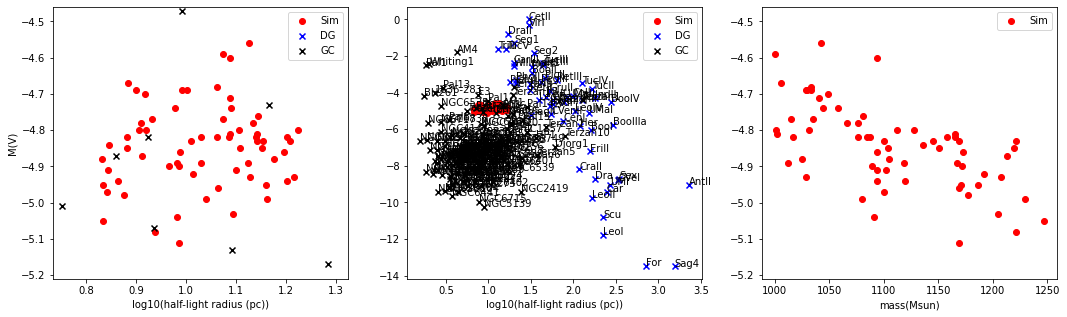

In [14]:
from ga_sim.plot import (
    general_plots,
    plot_ftp,
    plots_ang_size,
    plots_ref,
    plot_err,
    plot_clusters_clean
)

general_plots(param['star_clusters_simulated'], param['output_plots'])


Plot footprint map to check area.

In [ ]:
hpx_ftp = param['results_path'] + "/ftp_4096_nest.fits"

plot_ftp(hpx_ftp, param['star_clusters_simulated'],
         mockcat, param['ra_max'], param['ra_min'], param['dec_min'], param['dec_max'], param['output_plots'])


In [ ]:
# Diretório onde estão os arquivo _clus.dat
plots_ang_size(param['star_clusters_simulated'], param['results_path'],
               param['mmin'], param['mmax'], param['cmin'], param['cmax'],
               param['output_plots'])


In [ ]:
plots_ref(FeH_iso, param['output_plots'], param['star_clusters_simulated'])


Plotting errors in main magnitude band.

In [ ]:
# Plots to analyze the simulated clusters.
plot_err(mockcat, param['output_plots'])


## Removing stars close to each other

Now, we have to remove stars that are not detected in the pipeline of detection of the survey. In principle, the software used by detect sources is SExtractor, which parameter deblend is set to blend sources very close to each other.

To remove sources close to each other, the approach below (or the function on that) read catalogs from ipixels (HealPixels).
To each star the distance to all sources are calculated. If the second minimum distance (the first one is zero, since it is the iteration of the stars with itself) is less than the distance defined as a parameter of the function, the star is not listed in the filtered catalog.
The function runs in parallel, in order to run faster using all the cores of node.

Firstly, setting the string to read position of stars.

In [ ]:
@python_app
def clean_input_cat_dist_app(file_name, ra_str, dec_str, min_dist_arcsec):

    clean_input_cat_dist(
        file_name,
        ra_str,
        dec_str,
        min_dist_arcsec
    )


futures = list()

# Cria uma Progressbar (Opcional)
with tqdm(total=len(ipix_cats), file=sys.stdout) as pbar:
    pbar.set_description("Submit Parsls Tasks")

    # Submissão dos Jobs Parsl
    for i in ipix_cats:
        futures.append(
            clean_input_cat_dist_app(
                i, param['ra_str'], param['dec_str'], param['min_dist_arcsec'])
        )

        pbar.update()

# Espera todas as tasks Parsl terminarem
# Este loop fica monitarando as parsl.futures
# Até que todas tenham status done.
# Esse bloco todo é opcional

print("Tasks Done:")
with tqdm(total=len(futures), file=sys.stdout) as pbar2:
    # is_done é um array contendo True ou False para cada task
    # is_done.count(True) retorna a quantidade de tasks que já terminaram.
    is_done = list()
    done_count = 0
    while is_done.count(True) != len(futures):
        is_done = list()
        for f in futures:
            is_done.append(f.done())

        # Só atualiza a pbar se o valor for diferente.
        if is_done.count(True) != done_count:
            done_count = is_done.count(True)
            # Reset é necessário por que a quantidade de iterações
            # é maior que a quantidade de jobs.
            pbar2.reset(total=len(futures))
            # Atualiza a pbar
            pbar2.update(done_count)

        if done_count < len(futures):
            sleep(3)


After filtering stars in HealPixels, join all the HP into a single catalog called final cat.

In [ ]:
ipix_clean_cats = [i.split('.')[0] + '_clean_dist.fits' for i in ipix_cats]
join_cats_clean(ipix_clean_cats,
                param['final_cat'], param['ra_str'], param['dec_str'])


Plot clusters comparing filtered and not filtered stars in each cluster. The region sampled is the center of the cluster where the crowding is more intense.</br>
Below the clusters with stars were filtered by max distance.

In [ ]:
plot_clusters_clean(ipix_cats, ipix_clean_cats,
                    param['nside_ini'], param['ra_str'], param['dec_str'], 0.01, param['output_plots'])


The images below are the plots comparing simulations and real clusters.

In [ ]:
from IPython.display import Image, display
import glob

ims = glob.glob(param['output_plots'] + '/*.png')

for i in ims:
    display(Image(i))